# WARNING
## This is Deprecated
- This repository was used for report 2 but it is no longer supported
- it may as well work but we provide no guarantees

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import datetime as dt
import math
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

## Split data
- Merge labels and features into one table
- Split data from each city
- Split train and validation tables


In [3]:
train_split_size = 0.75

labels = pd.read_csv('../data/dengue_labels_train.csv')
features = pd.read_csv('../data/dengue_features_train.csv')
df = labels.merge(features)

sj_data = df[df.city == 'sj']
iq_data = df[df.city == 'iq']

sj_data = sj_data.reset_index()
iq_data = iq_data.reset_index()


def split(df, train_split_size):
    train_size = int(math.ceil(len(df)*train_split_size))
    val_size = int(math.floor((len(df)*(1-train_split_size))))
    return df[0:train_size], df[train_size:train_size+val_size]

def total_mae(len_sj, len_iq, mae_sj, mae_iq):
    mae = (mae_sj*len_sj+mae_iq*len_iq)/(len_sj+len_iq)
    return mae

sj_train, sj_val = split(sj_data, train_split_size)
iq_train, iq_val = split(iq_data, train_split_size)

# Random Baseline

Use each time series mean and std to generate an Normal i.i.d variable as baseline

In [4]:
def random_baseline(train_data, val_data):
    Y = train_data['total_cases'].values
    ymean = np.mean(Y)
    ystd = np.std(Y)
    Y_val = val_data['total_cases'].values
    Y_pred = np.random.normal(ymean, ystd, len(Y_val))
    
    error = mean_absolute_error(Y_val, Y_pred)
    
    return error
    
mae_sj = random_baseline(sj_train, sj_val)
print("San Juan Random Baseline MAE = {}".format(mae_sj))
mae_iq = random_baseline(iq_train, iq_val)
print("Iquitos Random Baseline MAE = {}".format(mae_sj))


mae_total = total_mae(len(sj_val), len(iq_val), mae_sj, mae_iq)
print("Total Validation MAE = {}".format(mae_total))
    

San Juan Random Baseline MAE = 46.48288269377377
Iquitos Random Baseline MAE = 46.48288269377377
Total Validation MAE = 33.90621788227213


# Regression on features (No temporal Data)

In [5]:
def treat_features(data):
    Y = data['total_cases'].values.reshape(-1, 1)
    data = data.drop(['index', 'total_cases', 'city', 'year', 'week_start_date', 'weekofyear'], axis=1)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    X = (data - data.mean()) / (data.max() - data.min())
    X = X.values
    return X, Y


def feature_regression(train_data, val_data):

    linear_regressor = LinearRegression()  # create object for the class

    X, Y = treat_features(train_data)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    print("Train MAE = {}".format(error))


    X, Y = treat_features(val_data)  # values converts it into a numpy array
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    print("Validation MAE = {}".format(error))
    return error
    
    
mae_sj = feature_regression(sj_train, sj_val)
mae_iq = feature_regression(iq_train, iq_val)

mae_total = total_mae(len(sj_val), len(iq_val), mae_sj, mae_iq)
print("Total Validation MAE = {}".format(mae_total))


Train MAE = 31.98444408167357
Validation MAE = 29.823997020174605
Train MAE = 5.40114382993373
Validation MAE = 8.06027711034363
Total Validation MAE = 22.05123990952068


# Temporal Regression

In [6]:
def treat_features(data, lag=1):
    Y = data['total_cases'].values.reshape(-1, 1)
    Y = np.log(1+Y)
    X = [[y[0] for y in Y[i:i+lag].tolist()] for i in range(0, len(Y)-lag)]
    Y = Y[lag:]
    return np.array(X), np.array(Y)


def fit_regression(data_train, data_val, lag):
    linear_regressor = LinearRegression()  # create object for the class

    X, Y = treat_features(data_train, lag=lag)

    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    error = mean_absolute_error(Y, Y_pred)
    train_mae = error
#     print("Train MAE = {}".format(error))

    X = [y[0] for y in Y[-lag:]]
    Y=[]
    for i in range(0, len(data_val)):
        nexty = linear_regressor.predict([X])[0][0]
        Y.append(nexty)
        X = X[1:] + [nexty]

    Y = np.exp(Y)-1
    true = data_val['total_cases'].values
    error = mean_absolute_error(true, Y)
    val_mae = error
#     print("Validation MAE = {}".format(error))
    return [lag, train_mae, val_mae]

Plot validation error versus number of samples in autoregressive model(p)

199.0


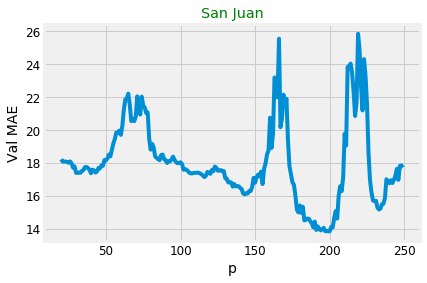

95.0


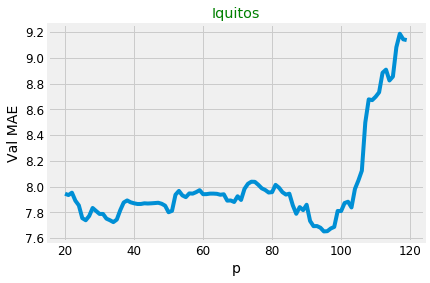

In [17]:
a = [fit_regression(sj_train, sj_val, lag=lag) for lag in range(20, 250, 1)]
a = np.array(a).T
print(a[0][a[2].argmin()])
plt.plot(a[0], a[2])
plt.title("San Juan")
plt.xlabel("p")
plt.ylabel("Val MAE")
plt.show()

a = [fit_regression(iq_train, iq_val, lag=lag) for lag in range(20, 120, 1)]
a = np.array(a).T
print(a[0][a[2].argmin()])
plt.plot(a[0], a[2])
plt.title("Iquitos")
plt.xlabel("p")
plt.ylabel("Val MAE")
plt.show()


# Causal Convolution DNNs

# SARIMA Models

In [18]:
# Treat Missing data
def treat_data(df_train, df_val):
    history = df_train['total_cases']
    history_exogenous = df_train.drop(['index', 'total_cases', 
                                       'city', 'year', 
                                       'week_start_date', 'weekofyear'], 
                                      axis=1)
    history_exogenous.fillna(method='ffill', inplace=True)
    val = df_val['total_cases']
    return history_exogenous


# Select features based on correlation threshold
def select_features(data, threshold):
    data = data.drop(['index', 'weekofyear', 'week_start_date', 'year'], axis=1)
    corr = data.corr()["total_cases"].abs().sort_values()
    corr = corr[corr > threshold]
    return corr.index



In [ ]:
#     decomposition = sm.tsa.seasonal_decompose(history, model='additive', freq=52)
#     print(decomposition)
#     fig = decomposition.plot()

In [20]:
def time_series_analysis(df_train, df_val, log_ratio=False, normalize=False, features=[], optimizer_kwargs={}):
    history = df_train['total_cases']
    val = df_val['total_cases']
    
#     decomposition = sm.tsa.seasonal_decompose(history, model='additive', freq=52)
#     print(decomposition)
#     fig = decomposition.plot()
    
    history_exogenous=None
    val_exogenous=None
    if len(features)>0:
        history_exogenous = df_train[features].drop('total_cases', axis=1)
        history_exogenous.fillna(method='ffill', inplace=True)
        history_exogenous.fillna(method='bfill', inplace=True)
        
        val_exogenous = df_val[features].drop('total_cases', axis=1)
        val_exogenous.fillna(method='ffill', inplace=True)
        val_exogenous.fillna(method='bfill', inplace=True)
        
        if normalize:
            tmean = history_exogenous.mean()
            tmax = history_exogenous.max()
            tmin = history_exogenous.min()
            history_exogenous = (history_exogenous - tmean) / (tmax - tmin)
            val_exogenous = (val_exogenous - tmean) / (tmax - tmin)
        
    
    if log_ratio:
        history = np.log(1+history)
        val = np.log(1+val)
    
    # Decomposition for visual analysis
    rcParams['figure.figsize'] = 18, 8
    
    # Fit a Sarimax Model with 1 year sasonality (cant get 3 years to work)
    mod = sm.tsa.statespace.SARIMAX(history, exog=history_exogenous, order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 52),
                                    enforce_stationarity=False, enforce_invertibility=False)

    results = mod.fit(**optimizer_kwargs)
    print('AIC:{}'.format(results.aic))
#     print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(18, 8))
#     plt.show()
    
    # Make a prediction for the validation set and compare with ground truth
    pred_uc = results.get_forecast(steps=len(val), exog=val_exogenous)
#     pred_ci = pred_uc.conf_int()
#     ax = val.plot(label='observed', figsize=(14, 4))
#     pred_uc.predicted_mean.plot(label='Forecast')
#     ax.fill_between(pred_ci.index[:],
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=.2)
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Registered Cases')
#     plt.legend()
#     plt.show()

    predictions = pred_uc.predicted_mean.values
    
    if log_ratio:
        history = np.exp(history)-1
        val = np.exp(val) -1
    
    error = mean_absolute_error(val, predictions)
    print('Test MAE: %.3f' % error)

    


In [9]:
# optimizer_kwargs = {
#     "method": "newton"
# }
# optimizer_kwargs = {"maxiter": 1,
#                     "time_varying_regression": True,
#                     "mle_regression": False}
# optimizer_kwargs = {}
# optimizer_kwargs = {}
# optimizer_kwargs = {"maxiter": 1}

In [ ]:
features = select_features(iq_train, 0.15)

time_series_analysis(iq_train, iq_val, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, log_ratio=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, normalize=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, log_ratio=True, normalize=True, optimizer_kwargs=optimizer_kwargs)

time_series_analysis(iq_train, iq_val, features=features,
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, normalize=True, 
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, log_ratio=True, 
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(iq_train, iq_val, features=features, log_ratio=True, normalize=True,
                     optimizer_kwargs=optimizer_kwargs)

In [ ]:
features = select_features(sj_train, 0.15)



time_series_analysis(sj_train, sj_val, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, normalize=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, log_ratio=True, optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, log_ratio=True, normalize=True, optimizer_kwargs=optimizer_kwargs)

time_series_analysis(sj_train, sj_val, features=features,
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, features=features, normalize=True,
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, features=features, log_ratio=True, 
                     optimizer_kwargs=optimizer_kwargs)
time_series_analysis(sj_train, sj_val, features=features, log_ratio=True, normalize=True,
                     optimizer_kwargs=optimizer_kwargs)